# pronóstico de series de tiempo

En esta notebook vamos a realizar el pronóstico de una serie de tiempo
1. Descargaremos los datos
2. Graficaremos la series para darnos una idea de su comportamiento
3. realizaremos una prueba de raíz unitaria para comprobrar si la serie es estacionaria
4. Diferenciaremos la serie en caso de que no sea estacionaria
5. Realizamos la prueba a la serie diferenciada para ver si es estacionaria
6. Graficaremos la serie estacionaria
7. realizaremos su ACF y PACF para tratar de identificar que tipo de proceso es MA(q), AR(P), ARMA(p,q), etc
8. Estimamos distintos modelos
9. Elegimos el modelo
10. Realizamos el pronóstico 

In [2]:
pip install yfinance

  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8488 sha256=6fb367a558e2d3f7af0d99ed89a45005036348606cce5f072a728855cea8f398
  Stored in directory: c:\users\migue\appdata\local\pip\cache\wheels\21\c9\66\b41c847de65c7985db52ec21d59996841598b8b0e93f2b9500
Successfully built multitasking
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
anaconda-project 0.9.1 requires ruamel-yaml, which is not installed.


In [61]:
# como siempre comenzamos importando las librerias
import numpy as np
import pandas as pd 
import yfinance as yf
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA


%matplotlib inline

In [62]:
#fijamos tamaño de graficas
plt.rcParams['figure.figsize'] = [10, 7.5]

## 1. Importamos los datos desde la api de yahoo finance

En mi caso yo voy a utilizar las acciones de amazon de México y voy a utilizar la información de los ultimos dos años hasta el día viernes, que es cuando estuvo abierta la bolsa

In [63]:
#recuerda instalar yahoo finance con-> pip install yfinance
amazon = yf.download('AMZN.MX', 
                       start='2019-12-01', 
                       end='2022-03-12',
                       progress=False)

In [64]:
#vemos los ultimos 10 datos
amazon.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-28,62843.460938,62843.460938,62161.000000,62243.000000,62243.000000,488
2022-03-01,62500.031250,62626.000000,62243.000000,62243.000000,62243.000000,267
2022-03-02,62310.718750,62850.000000,62310.718750,62850.000000,62850.000000,349
2022-03-03,62999.000000,63330.000000,61190.988281,61190.988281,61190.988281,377
2022-03-04,60555.980469,60940.000000,60470.000000,60833.839844,60833.839844,432
2022-03-07,60800.011719,61150.000000,58711.519531,58841.000000,58841.000000,1955
2022-03-08,58029.230469,59550.000000,57850.250000,58268.460938,58268.460938,755
2022-03-09,58800.000000,58800.000000,57650.000000,58110.000000,58110.000000,949
2022-03-10,60810.000000,62220.000000,60810.000000,61933.281250,61933.281250,9804


In [65]:
##Voy renombar columna 'Adj Close' por adj_close 
amazon.rename(columns = {'Adj Close':'adj_close'}, inplace=True)

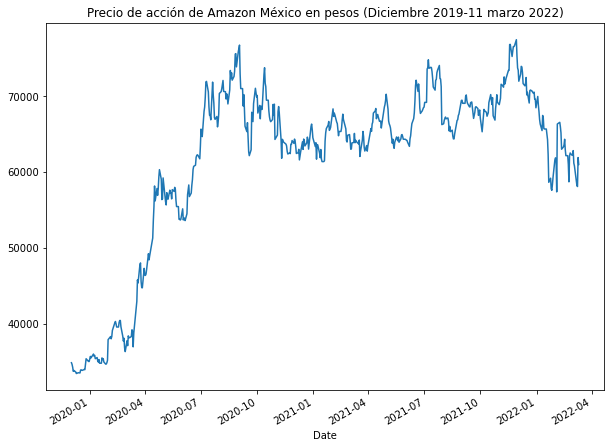

In [66]:
# vamos a graficar
amazon.adj_close.plot()
plt.title('Precio de acción de Amazon México en pesos (Diciembre 2019-11 marzo 2022)')
plt.show()

In [67]:
#hacemos la prueba de dickey fuller aumentada ADF
adf = adfuller(amazon['adj_close'])

#presentamos el p-value
print('p-value: %f' % adf[1])



p-value: 0.126550


Recuerda que $H_0$: serie no estacionaria

In [68]:
if adf[1] < 0.05:
    
    print(f'con un un p-value={adf[1].round(3)}\n Se rechaza hipótesis nula, serie estacionaria') 
    
else:
    
    print(f'con un un p-value = {adf[1].round(3)}\n NO se rechaza hipótesis nula, serie no estacionaria') 


con un un p-value = 0.127
 NO se rechaza hipótesis nula, serie no estacionaria


para hacer la serie estacionaria, usaremos lafunción shift de pandas 

y guardaremos la serie diferenciada en un objeto aparte

In [69]:
amazon_diff = amazon['adj_close'] - amazon['adj_close'].shift()

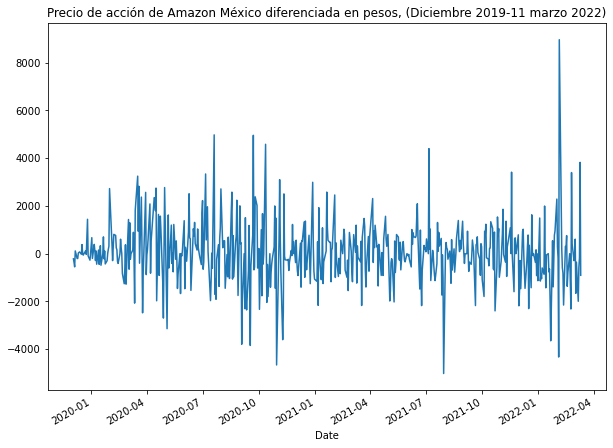

In [70]:
#graficamos el tipo de cambio diferenciado
amazon_diff.plot()
plt.title('Precio de acción de Amazon México diferenciada en pesos, (Diciembre 2019-11 marzo 2022)')
plt.show()

In [71]:
#eliminamos los Nan
amazon_diff = amazon_diff.dropna()

In [72]:
## como la serie tiene saltos (los fines de semana los mercados no abren)
## removeremos la fecha
amazon_diff = amazon_diff.reset_index()

### eliminamos columna fecha
amazon_diff = amazon_diff.drop(['Date'], axis=1)

In [73]:
amazon_diff

,adj_close
0,-216.398438
1,-367.492188
2,-551.597656
3,115.218750
4,-199.730469
...,...
568,-1992.839844
569,-572.539062
570,-158.460938
571,3823.281250


volvemos a realizar la prueba de raíz unitaria ADF

In [74]:
adf1 = adfuller(amazon_diff)
if adf1[1] < 0.05:
    
    print(f'con un un p-value={adf1[1]}\n Se rechaza hipótesis nula, serie estacionaria') 
    
else:
    
    print(f'con un un p-value = {adf1[1]}\n NO se rechaza hipótesis nula, serie no estacionaria') 


con un un p-value=0.0
 Se rechaza hipótesis nula, serie estacionaria


Ahora que la serie ya es estacionaria, podemos hacer pronósticos con ella
por tanto debemos identificar que tipo de proceso es


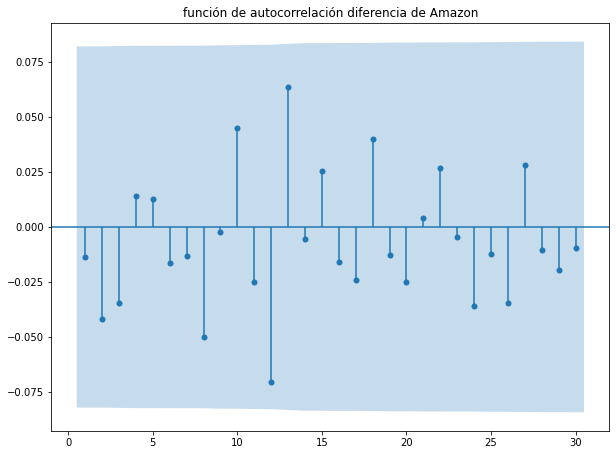

In [75]:
#grafica de autocorrelación ACF
plot_acf(amazon_diff, zero=False, lags=30)
plt.title('función de autocorrelación diferencia de Amazon')
plt.show()

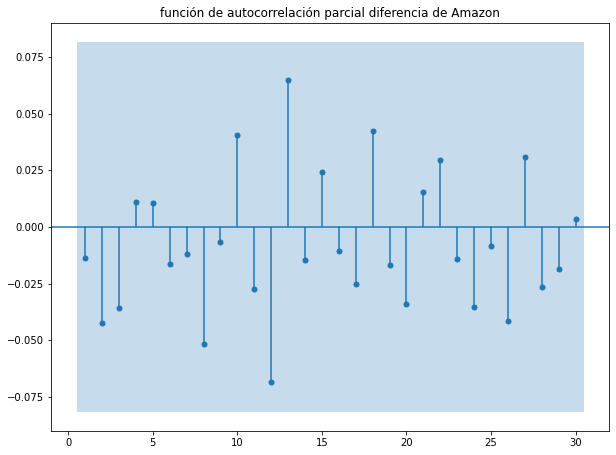

In [76]:
#grafica de autocorrelación parcial PACF
plot_pacf(amazon_diff, zero=False, lags=30)
plt.title('función de autocorrelación parcial diferencia de Amazon')
plt.show()

nota que el primer rezago de ACF y PACF es significativo, por lo que parece que la diferencia de las acciones de walmex es en ARMA (1,1) 

In [77]:
# estimamos un ARMA (1,1)
modelo = ARIMA(amazon_diff, order=(1, 0, 1))
resultado = modelo.fit()
resultado.summary()

C:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              adj_close   No. Observations:                  573
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -4915.443
Date:                Sun, 13 Mar 2022   AIC                           9838.885
Time:                        20:58:19   BIC                           9856.289
Sample:                             0   HQIC                          9845.674
                                - 573                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.6781     46.524      0.982      0.326     -45.508     136.864
ar.L1          0.8460      0.213      3.974      0.000       0.429       1.263
ma.L1         -0.8722      0.192     -4.554      0.000      -1.248      -0.497
sigma2      1.665e+06   5.57e+04     29.918      0.000    1.56e+06    1.77e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               726.69
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                             0.64
Prob(H) (two-sided):                  0.19   Kurtosis:                         8.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Note que la constante no es significativa, es decir, es cero. Pero los coeficientes de los rezagos si son significativos (distintos de cero) acuerdo con sus p-values

Aunque los ACF y PACF nos sugieren un ARMA(1,1), no son del todo precisos, asi que vamos a estimar varios modelos con 6 rezagos de AR, 6rezagos de MA y elegir uno de acuerdo con el BIC (criterio bayesiano de información)

In [78]:
ic = {}
for ar in range(10):
    for ma in range(10):
        print(f"AR: {ar}, MA: {ma}")
        modelo = ARIMA(amazon_diff, order=(ar, 0, ma))
        resultado = modelo.fit()
        ic[(ar, ma)] = [resultado.aic, resultado.bic]

ic = pd.DataFrame(ic, index=["AIC", "BIC"]).T
ic.index = ic.index.set_names(["AR", "MA"])
ic

AR: 0, MA: 0
AR: 0, MA: 1
AR: 0, MA: 2
AR: 0, MA: 3
AR: 0, MA: 4
AR: 0, MA: 5
AR: 0, MA: 6
AR: 0, MA: 7
AR: 0, MA: 8
AR: 0, MA: 9
AR: 1, MA: 0
AR: 1, MA: 1


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 1, MA: 2
AR: 1, MA: 3
AR: 1, MA: 4
AR: 1, MA: 5
AR: 1, MA: 6
AR: 1, MA: 7
AR: 1, MA: 8
AR: 1, MA: 9
AR: 2, MA: 0
AR: 2, MA: 1
AR: 2, MA: 2
AR: 2, MA: 3
AR: 2, MA: 4


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 2, MA: 5


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 2, MA: 6


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 2, MA: 7


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 2, MA: 8
AR: 2, MA: 9
AR: 3, MA: 0
AR: 3, MA: 1
AR: 3, MA: 2
AR: 3, MA: 3


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 4


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 5
AR: 3, MA: 6


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 7


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 8


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 9
AR: 4, MA: 0
AR: 4, MA: 1
AR: 4, MA: 2


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 3


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 4
AR: 4, MA: 5


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 6


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 7


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 8


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 9


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 0
AR: 5, MA: 1
AR: 5, MA: 2
AR: 5, MA: 3


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 4


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 5


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 6


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 7


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 8


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 9


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 0
AR: 6, MA: 1
AR: 6, MA: 2
AR: 6, MA: 3
AR: 6, MA: 4


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 5


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 6


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 7


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 8


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 9


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 7, MA: 0
AR: 7, MA: 1
AR: 7, MA: 2
AR: 7, MA: 3
AR: 7, MA: 4


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 7, MA: 5


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 7, MA: 6


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 7, MA: 7


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 7, MA: 8


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 7, MA: 9


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 8, MA: 0
AR: 8, MA: 1
AR: 8, MA: 2
AR: 8, MA: 3


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 8, MA: 4


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 8, MA: 5


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 8, MA: 6


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 8, MA: 7


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 8, MA: 8


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 8, MA: 9


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 9, MA: 0
AR: 9, MA: 1
AR: 9, MA: 2
AR: 9, MA: 3
AR: 9, MA: 4


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 9, MA: 5


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 9, MA: 6


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 9, MA: 7


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 9, MA: 8


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 9, MA: 9


C:\Users\migue\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC          BIC
AR MA                          
0  0   9836.255948  9844.957720
   1   9838.151767  9851.204424
   2   9839.146603  9856.550146
   3   9840.551347  9862.305776
   4   9842.527396  9868.632711
...            ...          ...
9  5   9855.548172  9925.162343
   6   9850.282731  9924.247788
   7   9857.909472  9936.225415
   8   9854.626402  9937.293231
   9   9857.676895  9944.694610

[100 rows x 2 columns]

los ordenamos de acuerdo al BIC que es el indicador que voy a utilizar

In [79]:
ic.sort_values('BIC', ascending = True)

AIC          BIC
AR MA                          
0  0   9836.255948  9844.957720
1  0   9838.150959  9851.203617
0  1   9838.151767  9851.204424
1  1   9838.885197  9856.288740
2  0   9839.125792  9856.529334
...            ...          ...
8  8   9854.369832  9932.685775
9  7   9857.909472  9936.225415
   8   9854.626402  9937.293231
8  9   9854.705528  9937.372357
9  9   9857.676895  9944.694610

[100 rows x 2 columns]

el BIC me sugiere un ARMA(1,1)

veamos que me sugiere el criterio de Akaike (AIC)

In [80]:
ic.sort_values('AIC', ascending = True)

,,AIC,BIC
AR,MA,,
0,0,9836.255948,9844.957720
1,0,9838.150959,9851.203617
0,1,9838.151767,9851.204424
1,1,9838.885197,9856.288740
2,0,9839.125792,9856.529334
...,...,...,...
9,5,9855.548172,9925.162343
7,8,9856.271264,9930.236321
8,7,9856.451683,9930.416740


criterio de AIC tambien me sugiere ARMA (1,1)

In [81]:
# estimamos un ARMA (1,1)
modelo = ARIMA(amazon_diff, order=(0, 0, 0))
resultado = modelo.fit()
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              adj_close   No. Observations:                  573
Model:                          ARIMA   Log Likelihood               -4916.128
Date:                Sun, 13 Mar 2022   AIC                           9836.256
Time:                        21:03:32   BIC                           9844.958
Sample:                             0   HQIC                          9839.650
                                - 573                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.6775     55.486      0.823      0.410     -63.072     154.427
sigma2       1.66e+06    5.2e+04     31.916      0.000    1.56e+06    1.76e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               781.43
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.67
Prob(H) (two-sided):                  0.17   Kurtosis:                         8.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

En realidad, en este caso, como diferenciamos una vez la serie de tiempo estacionaria para hacerla estacionaria, nuestro modelo ARMA (1,1), es un ARIMA(1,1,1) de la serie original

In [82]:
# estimamos un ARIMA (0,0)
modelo2 = ARIMA(amazon['adj_close'], order=(0, 1, 0))
resultado2 = modelo2.fit()
resultado2.summary()

C:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              adj_close   No. Observations:                  574
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4916.489
Date:                Sun, 13 Mar 2022   AIC                           9834.977
Time:                        21:03:38   BIC                           9839.328
Sample:                             0   HQIC                          9836.674
                                - 574                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.658e+06      5e+04     33.149      0.000    1.56e+06    1.76e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               781.43
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                             0.67
Prob(H) (two-sided):                  0.20   Kurtosis:                         8.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
# vamos a estimar la serie con el modelo ARIMA
amazon['pronostico'] = resultado2.predict()
amazon['pronostico'][0] = amazon['adj_close'][0]

<ipython-input-83-c9ab981f76e5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon['pronostico'][0] = amazon['adj_close'][0]


graficamos la y_estimada con la y_original

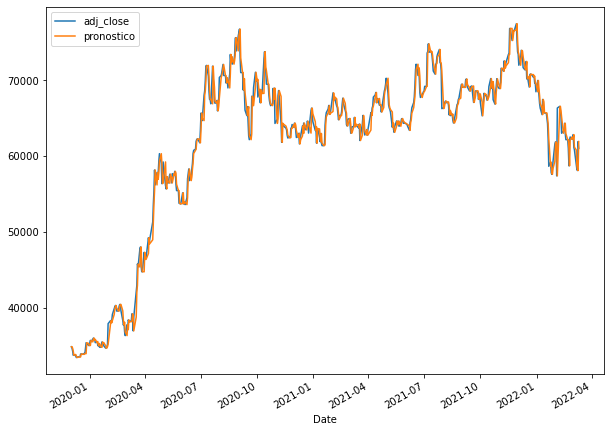

In [84]:
amazon[['adj_close', 'pronostico']].plot()
plt.show()

In [85]:
#calculamos cuantas observaciones tenemos para hacer nuestra predicción
len(amazon)

574

la función len nos arrojo que tenemos 574 observaciones,  quiere decir que el lunes sería la observación 575, el martes la 576, y el miércoles la 577

In [86]:
## vamos a pronosticar esos días
resultado2.predict(574, 577)

C:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


574    61028.070312
575    61028.070312
576    61028.070312
577    61028.070312
Name: predicted_mean, dtype: float64

# mi pronostico para el lunes 14 de marzo es que la acción de Amazon tenga un precio de cierre (ajustado) de 61001.070593

El viernes cerro en 78.7399